# Get g-memberships from two k-distributions using g-thresholds that have been used in lblnew.f

In [1]:
%matplotlib inline
from IPython import display
import os, sys

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib 
import matplotlib.pyplot as plt

In [2]:
matplotlib.rc('font', size=13)

# O3 band 5 absorption coefficient

In [4]:
# for loading absorption coefficient calculated using line-by-line
# k(v, pt)

def get_data_file_paths():
    
    dir_common = os.path.join('/nuwa_cluster/home/jackyu',
                              'radiation/crd/LW/examples',
                              'separate_g_groups',
                              'study__lblnew_g1_threshold',
                              'o3',
                              'band05_wn_980_1100',
                              'P_50_T_250_min_1e-20_max_5e-18_ng_20_dlogN_uniform__P_1_T_250',
                              'ighigh_7',
                              'wgt_1_1_1_1_1_1_1_.7_.7_.7_.7_.7_.7_.7_.7_.7_.7_.7_.7',
                              'midlatitude_summer')
    
    dir_runs = ['']
    
    path_runs = [os.path.join(dir_common, dir_run, 'output_abshl.dat')
                 for dir_run in dir_runs]
    return path_runs



def load_absgas_file(path_absgas):
    df = pd.read_csv(path_absgas, sep=r'\s+')
    df = df.set_index(['v', 'pressure', 'temperature'])
    
    ds = xr.Dataset.from_dataframe(df)
    ds = ds.stack(pt=('pressure', 'temperature'))
    ds.coords['ipt'] = ('pt', range(1, ds.dims['pt'] + 1))
    return ds   
    

    
def load_absgas_files(paths_absgas):
    dss = [load_absgas_file(fpath) for fpath in paths_absgas]
    return xr.concat(dss, dim='pt')



def o3_band5_limits():
    return {'min': 980, 'max': 1100}



def ref_pts():
    return {'low': (50, 250), 'high': (1, 250)}




def get_tworef_dataframe(ds, min_wvn=0, max_wvn=3000, pts=None):
    if pts == None:
        pts = [(50, 250)]
        
    pts = sorted([pt for _, pt in ref_pts().items()],
                 key=lambda x: x[0])
    return ds['absgas'].sel(pt=pts, v=slice(min_wvn, max_wvn))\
           .to_pandas()


In [5]:
ds = load_absgas_files(get_data_file_paths())

In [6]:
vlims = o3_band5_limits()
pts = [pt for _, pt in ref_pts().items()]

df = get_tworef_dataframe(ds, 
                          min_wvn=vlims['min'],
                          max_wvn=vlims['max'],
                          pts=pts)

In [7]:
df.head()

pressure,1,50
temperature,250,250
v,,
980.0025,7.967141e-22,4.541210e-21
980.0075,3.822608e-23,1.556828e-21
980.0125,1.964540e-23,9.081155e-22
980.0175,2.647618e-23,9.808063e-22
980.0225,5.996942e-21,1.532382e-21


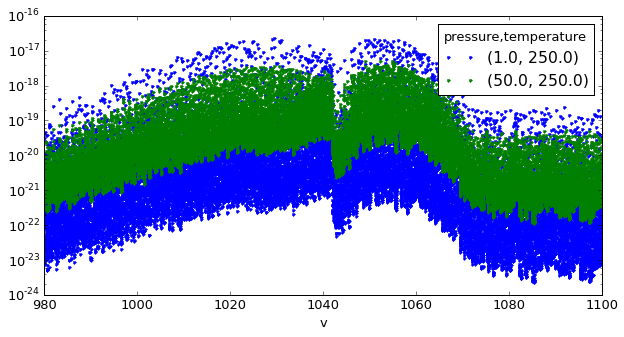

In [8]:
# have a look at the k at the two reference pt's.
df.plot(logy=True, figsize=(10, 5),
        linestyle='None', marker='.')

# Sorting k

In [16]:
def get_absth():
    '''
    These are the absth values specified in lblnew.f
    '''
    return {'high': np.array([2.0000000e-22, 3.84708783e-22, 
                              7.40004238e-22, 1.42343065e-21, 
                              2.73803136e-21, 5.26672357e-21,
                              1.01307741e-20, 1.94869888e-20,
                              3.74840787e-20, 7.21022715e-20, 
                              1.38691886e-19, 2.66779933e-19,
                              5.13162916e-19, 9.87091404e-19,  
                              1.89871366e-18, 3.65225911e-18,  
                              7.02528079e-18, 1.35134361e-17,
                              2.59936878e-17, 5.00000000e-17]),
            'low': np.array([1.000e-20, 1.387e-20,   
                             1.924e-20, 2.668e-20, 
                             3.700e-20, 5.132e-20,
                             7.117e-20, 9.871e-20,  
                             1.369e-19, 1.899e-19,   
                             2.633e-19, 3.652e-19,
                             5.065e-19, 7.025e-19, 
                             9.743e-19, 1.351e-18,  
                             1.874e-18, 2.599e-18,
                             3.605e-18, 5.000e-18])}



def value_bins(absth):
    return np.concatenate(([0], absth[1:-1], [1]), axis=0)


def g_high_inclusive():
    "the lowest g that is from sorting k at pt_high"
    return 8


def ng_tot():
    return 20


def find_ggroup_membership(kdist, absth, labels=None):
    '''
    Map each spectral point (or wavenumber) to a g-group,
    based on the distribution of k and the g-groups, defined
    by their upper and lower limits.
    '''
    bins = value_bins(absth)
    ng = len(absth) - 1
    
    if labels == None:
        labels = range(1, ng + 1)

    return pd.cut(kdist, bins=bins, 
                  labels=labels, 
                  right=False,
                  include_lowest=True,
                  retbins=True)

In [31]:
# sort using the low reference

ng_low = g_high_inclusive() - 1

srs = df[ref_pts()['low']]

absth_low = np.concatenate(([0], get_absth()['low']), axis=0)

ncut_low = find_ggroup_membership(srs, absth_low)

grouped_low = srs.groupby(ncut_low[0])


print('Low reference absth')
print(absth_low)
print()
print('Low reference fractional size of g-groups')
grouped_low.size() / grouped_low.size().sum()

Low reference absth
[  0.00000000e+00   1.00000000e-20   1.38700000e-20   1.92400000e-20
   2.66800000e-20   3.70000000e-20   5.13200000e-20   7.11700000e-20
   9.87100000e-20   1.36900000e-19   1.89900000e-19   2.63300000e-19
   3.65200000e-19   5.06500000e-19   7.02500000e-19   9.74300000e-19
   1.35100000e-18   1.87400000e-18   2.59900000e-18   3.60500000e-18
   5.00000000e-18]

Low reference fractional size of g-groups


(50.0, 250.0)
1     0.410750
2     0.049083
3     0.055958
4     0.060833
5     0.060500
6     0.058417
7     0.052542
8     0.045083
9     0.039458
10    0.033625
11    0.027042
12    0.025250
13    0.019375
14    0.018083
15    0.013875
16    0.010625
17    0.009333
18    0.005958
19    0.003542
20    0.000667
dtype: float64

In [12]:
# get the spectral points that are in g-groups ng_low + 1 ~ ng

wvns_high = ncut_low[0][ncut_low[0] >= g_high_inclusive()]

In [30]:
# sort at high reference at these leftover spectral points

ng_high = ng_tot() - g_high_inclusive() + 1

srs = df[ref_pts()['high']][wvns_high.index]


absth_high = np.logspace(np.log10(srs.min()),
                         np.log10(srs.max()), 
                         ng_high + 1)

labels = range(g_high_inclusive(), ng_tot() + 1)

ncut_high = find_ggroup_membership(srs, absth_high, 
                                   labels=labels)

grouped_high = srs.groupby(ncut_high[0])

print('k-distribution at high reference at leftover spectral points')
print(srs.describe())
print()
print('High reference absth')
print(absth_high)
print()
print('High reference fractional size of g-groups')
(grouped_high.size() / grouped_high.size().sum())

k-distribution at high reference at leftover spectral points
count    6.046000e+03
mean     4.773566e-19
std      1.932354e-18
min      1.455004e-21
25%      4.306746e-21
50%      1.229633e-20
75%      6.545187e-20
max      2.315897e-17
Name: (1.0, 250.0), dtype: float64

High reference absth
[  1.45500420e-21   3.06255475e-21   6.44619556e-21   1.35682267e-20
   2.85589809e-20   6.01121583e-20   1.26526629e-19   2.66318632e-19
   5.60558788e-19   1.17988799e-18   2.48347845e-18   5.22733111e-18
   1.10027090e-17   2.31589700e-17]

High reference fractional size of g-groups


(1.0, 250.0)
8     0.159113
9     0.195501
10    0.166060
11    0.132815
12    0.088654
13    0.063348
14    0.048296
15    0.041515
16    0.030268
17    0.024810
18    0.020509
19    0.019186
20    0.009924
dtype: float64

In [19]:
# Gather the `ng_low`  g-groups first obtained along 
# with these `ng - ng_low` g-groups to get an overall `ng` g-groups

mem_high = ncut_high[0]
mem_low = ncut_low[0][ncut_low[0] < g_high_inclusive()]

mem_low = mem_low.astype(np.int64)
mem_high = mem_high.astype(np.int64)

srs_mem = pd.concat([mem_low, mem_high], axis=0)
srs_mem.sort_index(inplace=True)


In [20]:
# Check that size of union of the two sets (low and high) of wavenumbers make up
# the original set

# Check that the two sets (low and high) of wavenumbers have no common wavenumbers

assert len(set(mem_low.index).union(set(mem_high.index))) == df.index.shape[0]
assert set(mem_low.index).intersection(set(mem_high.index)) == set({})

In [21]:
print('size of union =       ', len(set(mem_low.index).union(set(mem_high.index))))
print('size of intersection =      ', len(set(mem_low.index).intersection(set(mem_high.index))))

size of union =        24000
size of intersection =       0


In [29]:
# Look at relative g-group sizes (or the k-distribution function)

grouped = srs_mem.groupby(srs_mem)

print('Overall fractional g-group sizes')
(grouped.size() / grouped.size().sum())

Overall fractional g-group sizes


1     0.410750
2     0.049083
3     0.055958
4     0.060833
5     0.060500
6     0.058417
7     0.052542
8     0.040083
9     0.049250
10    0.041833
11    0.033458
12    0.022333
13    0.015958
14    0.012167
15    0.010458
16    0.007625
17    0.006250
18    0.005167
19    0.004833
20    0.002500
dtype: float64

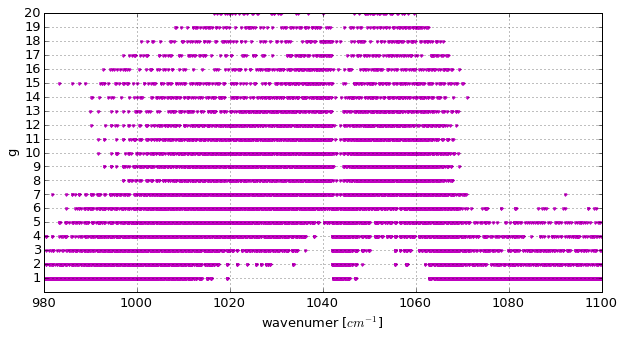

In [23]:
# plot g-group number vs wavenumber for all spectral points

ng = ng_tot()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
ax.plot(srs_mem.index, srs_mem.values, 
        color='m', linestyle='None', marker='.')

ax.grid(b=True)

ax.set_yticks(range(1, ng + 1))
ax.set_yticklabels(range(1, ng + 1))
ax.set_ylabel('g')

ax.set_xlabel('wavenumer [$cm^{-1}$]')

In [32]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
